## Neural Networks Learning using Numpy

In [1]:
%matplotlib inline
# To get nice quality plots
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sop
from scipy.io import loadmat

### Read Data

In [2]:
# Read data
data = loadmat('data/ex4data1.mat')
X = data['X']
y = data['y']
(m, n) = X.shape
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (5000, 400), y shape: (5000, 1)


### Visualize Data

In [3]:
# Function to show some random immages of handwritten numbers
def displayData(X, nr_examples):
    m, n = X.shape
    example_width = int(np.round(np.sqrt(n)))
    example_height = n // example_width
    
    display_rows = int(np.floor(np.sqrt(nr_examples)))
    display_cols = int(np.ceil(nr_examples / display_rows))
    
    _, axarr = plt.subplots(display_rows, display_cols, figsize=(display_rows, display_cols))
    
    for i in range(display_rows):
        for j in range(display_cols):
            axarr[i,j].imshow(X[np.random.randint(m)].reshape(example_width, example_height, order = 'F'), 
                              cmap='gray')
            axarr[i,j].axis('off')

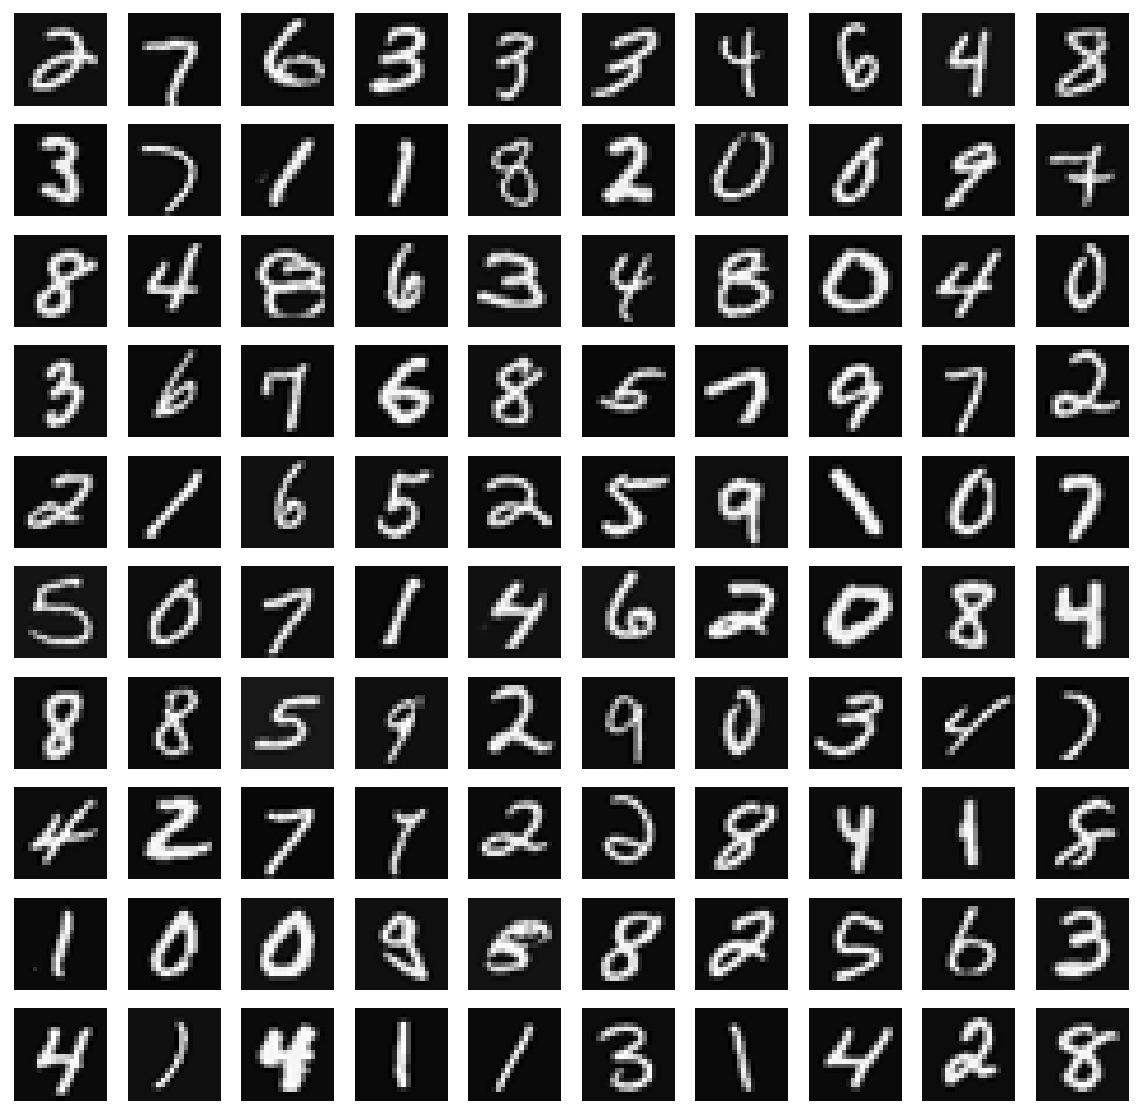

In [4]:
# Show some images
displayData(X, 100)

### Load pre-learned Weights

In [5]:
data_param = loadmat('data/ex4weights.mat')
Theta1 = data_param['Theta1']
Theta2 = data_param['Theta2']
params = np.r_[Theta1.ravel(), Theta2.ravel()]
print("Shape of Theta1: ", Theta1.shape, "\nShape of Theta2: ", Theta2.shape, "\nShape of params: ", params.shape)

Shape of Theta1:  (25, 401) 
Shape of Theta2:  (10, 26) 
Shape of params:  (10285,)


### Model

In [6]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [7]:
def sigmoidGradient(z):
    g = sigmoid(z)
    return g * (1 - g) 

In [8]:
# Define cost function for neural network: nn_params is the unrolled parameter vector

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lam):
    # Reconstruct Theta1 and Theta2 from parameter vector
    Theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size + 1)], 
                        (hidden_layer_size, (input_layer_size + 1)))
    Theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size + 1):], 
                        (num_labels, (hidden_layer_size + 1)))
    # Number of samples = size of input layer
    m = X.shape[0]
    
    # Transform label vector into matrix of binary label vectors:
    y_mat = pd.get_dummies(y.ravel()).values
    
    ## Compute cost -> forward propagation
    # Input layer: Add bias column to X
    a1 = np.c_[np.ones((m, 1)), X]
    
    # Hidden layer: calculate activation
    z2 = a1 @ Theta1.T
    a2 = np.c_[np.ones((m, 1)), sigmoid(z2)]
    
    #Output layer: calculate activation
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)
    
    # Compute cost function value
    J = -(1/m) * np.sum((np.log(a3) * y_mat + np.log(1 - a3) * (1 - y_mat))) + \
         (lam/(2*m)) * (np.sum(Theta1[:,1:] ** 2) + np.sum(Theta2[:,1:] ** 2))
    
    ## Backpropagation to calculate gradients
    # Output layer: compute error
    delta3 = a3 - y_mat
    
    # Hidden layer: compute error
    delta2 = delta3 @ Theta2[:,1:] * sigmoidGradient(z2)
    Delta2 = delta3.T @ a2
    
    # Input layer:
    Delta1 = delta2.T @ a1
    
    # Gradients of costfunction with respect to Theta1 and Theta2
    D1 = (1/m) * Delta1
    D2 = (1/m) * Delta2
    
    # Add regulatrisation part
    D1[:, 1:] += (lam/m) * Theta1[:,1:]
    D2[:, 1:] += (lam/m) * Theta2[:,1:]
    
    return (J, np.r_[D1.ravel(), D2.ravel()])

In [9]:
# Function to randomly initialize weights:
def randInitWeights(L_in, L_out):
    # From course, random weight values are chosen in the intervall [-espilon_init, epsilon_init]
    epsilon_init = np.sqrt(6)/np.sqrt(L_in + L_out)
    return np.random.rand(L_out, L_in + 1) * 2 * epsilon_init - epsilon_init

In [10]:
# Define parameters of neural network
input_layer_size = X.shape[1]
hidden_layer_size = Theta1.shape[0]
num_labels = Theta2.shape[0]

# Unregularized cost
nnCostFunction(params, input_layer_size, hidden_layer_size, num_labels, X, y, 0)[0]

0.2876291651613189

In [11]:
# Regularized cost (lambda = 1)
nnCostFunction(params, input_layer_size, hidden_layer_size, num_labels, X, y, 1)[0]

0.38376985909092365

In [12]:
# Compute random initial Thetas
initial_Theta1 = randInitWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.r_[initial_Theta1.ravel(), initial_Theta2.ravel()]

In [13]:
# Function for neural network training

def trainNN(init_nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lam, max_iter):
    # Notice: nnCostFunctio calculates the cost functio AND the (unrolled) gradient wrt Theta, jac = True tells the
    #         minimizer that the gardient is calculated in the supplied function
    result = sop.minimize(nnCostFunction, x0 = init_nn_params, jac=True, \
                          args = (input_layer_size, hidden_layer_size, num_labels, X, y, lam), \
                          method='CG', options = {'maxiter': max_iter}).x
    
    # Reconstruct Theta1 and Theta2 from parameter vector
    Theta1 = np.reshape(result[:hidden_layer_size*(input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))
    Theta2 = np.reshape(result[hidden_layer_size*(input_layer_size + 1):], (num_labels, (hidden_layer_size + 1)))
    
    return (Theta1, Theta2)

In [14]:
# Parameters
lam = 1
maxiter = 100

# Train
Theta1_opt, Theta2_opt = trainNN(initial_nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lam, maxiter)

### Results

In [15]:
# Define prediction function
def predict(Theta1, Theta2, X):
    # m1 is the input layer size
    m1 = X.shape[0]
    # Input Layer: add bias column to X
    a1 = np.c_[np.ones((m1, 1)), X]
    # Hidden Layer: calculate activation
    z2 = a1 @ Theta1.T
    a2 = np.c_[np.ones((m1, 1)), sigmoid(z2)]
    # Output Layer: calculate activation
    z3 =  a2 @ Theta2.T
    # no need to add bias unit!
    a3 = sigmoid(z3)
    # calculate actual predictions
    return (np.argmax(a3, axis = 1) + 1)

In [16]:
# Calculate predictions
pred = predict(Theta1_opt, Theta2_opt, X)

# Calculate percentage of correct classifications on training set
np.mean(pred == y.flatten())

0.9832

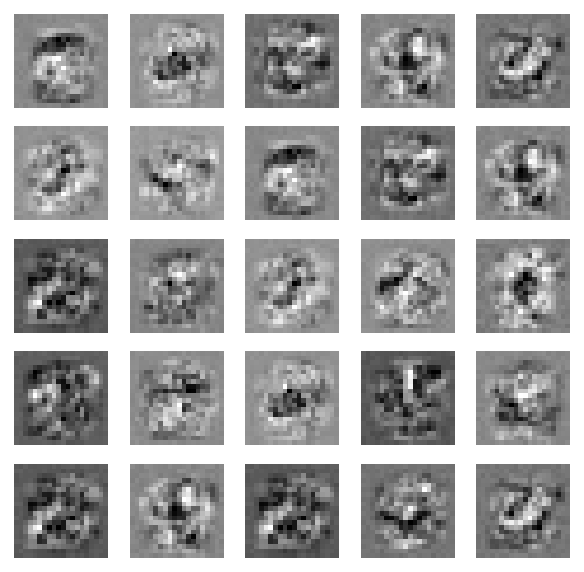

In [17]:
# Visualize hidden unit:
displayData(Theta1_opt[:, 1:], 25)